In [2]:
from numba.core.extending import get_cython_function_address
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import pytz
import pvlib

In [3]:
main_path = "/Users/nataly/opt/AnacondaProjects/SAPIENS/CLEAN/" 
BSRN_path = "/Users/nataly/opt/AnacondaProjects/SAPIENS/BSRN/" 

ghi =  ['GHIP_SI02pt100',
        'GHIP_SMP11',
        'GHIP_SMP22',
        'GHIP_SPN1',
        'GHIT_SMP22']

gti = ['TGHIP_SI02pt100', 
       'TGHIP_SI02pt100_dirty',
       'TGIP_SMP11_VENT']
      
dif = ['DfHIP_SPN1', 
       'DfHIRP_SMP11',
       'DfHIT_SMP22',
       'DIF_GLO_REF_SPN1']

dni = ['DNI_SHP1']

months = ['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
          '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
          '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
          '2021-01']

years = ['2018', '2019', '2020', '2021']

In [3]:
year = years[2]

In [5]:
location = pvlib.location.Location(-27.430891, -48.441406, tz = 'Brazil/East',altitude= 2.74, name = 'Florianopolis')  # check for daylight savings 'Etc/GMT-3' 'America/Sao_Paulo'

missing = pd.DataFrame(columns= ['days'], index = years) # count data record missing in a year, for each year. IN THE DATALOGGER. individual sensor may have empty entries not accounted for

ghiFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin',
                                 'F_GHIP_SI02pt100', 'F_GHIP_SMP11', 'F_GHIP_SMP22', 
                                 'F_GHIP_SPN1', 'F_GHIT_SMP22'])

difFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin'
                                  'F_DfHIP_SPN1', 'F_DfHIRP_SMP11', 'F_DfHIT_SMP22',
                                  'DIF_GLO_REF_SPN1'])  

dniFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin', 'F_DNI_SHP1'])

PPmin = -4  # minimum physically possible limit
ERmin = -2  # minimum extremely rare limit

flags = [-1, #NaN
          -2, #-9999
           3, # too low PP
           1, # too low ER
           2, # too high ER
           4] # too high PP

ghiflagcount = pd.DataFrame(columns= [ghi], index = [-2, -1, 0, 1, 2, 3, 4], dtype = int) 
difflagcount = pd.DataFrame(columns= [ghi], index = [-2, -1, 0, 1, 2, 3, 4], dtype = int) 
dniflagcount = pd.DataFrame(columns= [ghi], index = [-2, -1, 0, 1, 2, 3, 4], dtype = int) 

In [7]:
    dfghi = pd.read_pickle(main_path+year+'GHI.pkl')
    #dfgti = pd.read_pickle(main_path+year+'GTI.pkl')
    dfdif = pd.read_pickle(main_path+year+'DIF.pkl')
    dfdni = pd.read_pickle(main_path+year+'DNI.pkl')

    dfghi.index = dfghi.index.tz_localize(location.tz)
    #dfgti.index = dfgti.index.tz_localize(location.tz)
    dfdif.index = dfdif.index.tz_localize(location.tz)
    dfdni.index = dfdni.index.tz_localize(location.tz)

    naive_times = pd.date_range(start = dfghi.index.min(), end = dfghi.index.max(), freq='1s', tz = location.tz)
    naive_times = pd.DatetimeIndex(naive_times)   # PROBLEM: WILL HAVE TO DEAL WITH MISSING VALUES

    missing.loc[year] = (len(naive_times) - len(dfghi.index))/3600/24

    eth = pvlib.irradiance.get_extra_radiation(naive_times, solar_constant = 1366.1, method = 'nrel').to_frame()
    solpos = pvlib.solarposition.get_solarposition(naive_times, location.latitude, location.longitude, location.altitude, pressure = 101293, temperature = 25)

    #cosSZA = pd.DataFrame(index = naive_times, columns=['caz'])
    cosSZA = np.cos(np.deg2rad(solpos.azimuth)).to_frame()
   
    ghiFLAG['PPmax'] = eth[0]*1.5*(cosSZA.azimuth**(1.2)) + 100   # PPMAX TOO LOW! CHECK PROBLEMS WITH CALCULATION
    ghiFLAG['PPmin'] = PPmin
    ghiFLAG['ERmax'] = eth[0]*1.2*(cosSZA.azimuth**(1.2)) + 50
    ghiFLAG['ERmin'] = ERmin

    difFLAG['PPmax'] = eth[0]*0.95*(cosSZA.azimuth**(1.2))+ 50
    difFLAG['PPmin'] = PPmin
    difFLAG['ERmax'] = eth[0]*0.75*(cosSZA.azimuth**(1.2))+ 30
    difFLAG['ERmin'] = ERmin
    
    dniFLAG['PPmax'] = eth[0]
    dniFLAG['PPmin'] = PPmin
    dniFLAG['ERmax'] = eth[0]*0.95*(cosSZA.azimuth**(0.2)) +10
    dniFLAG['ERmin'] = ERmin

    ghiFLAG = pd.merge(ghiFLAG, dfghi, left_index = True, right_index = True, how='outer')  # index by naive times. how = 'inner': index by recorded times.
    difFLAG = pd.merge(difFLAG, dfdif, left_index = True, right_index = True, how='outer')  # index by naive times. how = 'inner': index by recorded times.
    dniFLAG = pd.merge(dniFLAG, dfdni, left_index = True, right_index = True, how='outer')  # index by naive times. how = 'inner': index by recorded times.

In [13]:
difFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin'
                                  'F_DfHIP_SPN1', 'F_DfHIRP_SMP11', 'F_DfHIT_SMP22',
                                  'F_DIF_GLO_REF_SPN1'])  

In [15]:
    difFLAG['PPmax'] = eth[0]*0.95*(cosSZA.azimuth**(1.2))+ 50
    difFLAG['PPmin'] = PPmin
    difFLAG['ERmax'] = eth[0]*0.75*(cosSZA.azimuth**(1.2))+ 30
    difFLAG['ERmin'] = ERmin
    

In [16]:
    difFLAG = pd.merge(difFLAG, dfdif, left_index = True, right_index = True, how='outer')  # index by naive times. how = 'inner': index by recorded times.


In [18]:
    for column in ghi:
        conditions = [ghiFLAG[column].isna(), 
                      ghiFLAG[column]== -9999, 
                      ghiFLAG[column] < ghiFLAG['PPmin'],
                     (ghiFLAG[column] > ghiFLAG['PPmin']) & (ghiFLAG[column]< ghiFLAG['ERmin']),
                     (ghiFLAG[column] > ghiFLAG['ERmax']) & (ghiFLAG[column]< ghiFLAG['PPmax']),
                      ghiFLAG[column] > ghiFLAG['PPmax']]
        flagcolumn = 'F_'+column
        ghiFLAG[flagcolumn] = np.select(conditions, flags, 0)
        ghiflagcount[column]= ghiFLAG[flagcolumn].value_counts()
    
    ghiFLAG.to_pickle(BSRN_path + year +'ghiFLAG.pkl')
    ghiflagcount.to_pickle(BSRN_path + year +'ghiflagcount.pkl')


    for column in dif:
        conditions = [difFLAG[column].isna(), 
                      difFLAG[column]== -9999, 
                      difFLAG[column] < difFLAG['PPmin'],
                     (difFLAG[column] > difFLAG['PPmin']) & (difFLAG[column]< difFLAG['ERmin']),
                     (difFLAG[column] > difFLAG['ERmax']) & (difFLAG[column]< difFLAG['PPmax']),
                      difFLAG[column] > difFLAG['PPmax']]
        flagcolumn = 'F_'+column
        difFLAG[flagcolumn] = np.select(conditions, flags, 0)
        difflagcount[column]= difFLAG[flagcolumn].value_counts()

    difFLAG.to_pickle(BSRN_path + year +'difFLAG.pkl')
    difflagcount.to_pickle(BSRN_path + year +'difflagcount.pkl')

    for column in dni:
        conditions = [dniFLAG[column].isna(), 
                      dniFLAG[column]== -9999, 
                      dniFLAG[column] < dniFLAG['PPmin'],
                     (dniFLAG[column] > dniFLAG['PPmin']) & (dniFLAG[column]< dniFLAG['ERmin']),
                     (dniFLAG[column] > dniFLAG['ERmax']) & (dniFLAG[column]< dniFLAG['PPmax']),
                      dniFLAG[column] > dniFLAG['PPmax']]
        flagcolumn = 'F_'+column
        dniFLAG[flagcolumn] = np.select(conditions, flags, 0)
        dniflagcount[column]= dniFLAG[flagcolumn].value_counts()

    dniFLAG.to_pickle(BSRN_path + year +'dniFLAG.pkl')
    dniflagcount.to_pickle(BSRN_path + year +'dniflagcount.pkl')

In [20]:
ghiflagcount

,GHIP_SI02pt100,GHIP_SMP11,GHIP_SMP22,GHIP_SPN1,GHIT_SMP22
-1,9475793.0,9475793,9475793,9475793.0,9475793
0,20315587.0,9442237,19703232,20142483.0,20358534
1,NaN,3161448,473905,NaN,495824
2,570879.0,615753,628556,632488.0,266498
3,NaN,7614696,5622,NaN,612339
4,1260614.0,1312946,1335765,1372109.0,413885


In [21]:
difflagcount

,GHIP_SI02pt100,GHIP_SMP11,GHIP_SMP22,GHIP_SPN1,GHIT_SMP22,DfHIP_SPN1,DfHIRP_SMP11,DfHIT_SMP22,DIF_GLO_REF_SPN1
-1,NaN,NaN,NaN,NaN,NaN,9475793.0,9475793,9475793,9475793
0,NaN,NaN,NaN,NaN,NaN,20802792.0,19925045,20364739,4330702
1,NaN,NaN,NaN,NaN,NaN,NaN,495824,521220,7513821
2,NaN,NaN,NaN,NaN,NaN,398731.0,310864,361088,262
3,NaN,NaN,NaN,NaN,NaN,NaN,612339,6664,10302064
4,NaN,NaN,NaN,NaN,NaN,945557.0,803008,893369,231


In [22]:
dniflagcount

,GHIP_SI02pt100,GHIP_SMP11,GHIP_SMP22,GHIP_SPN1,GHIT_SMP22,DNI_SHP1
-1,NaN,NaN,NaN,NaN,NaN,9475793.0
0,NaN,NaN,NaN,NaN,NaN,19215205.0
1,NaN,NaN,NaN,NaN,NaN,2693005.0
2,NaN,NaN,NaN,NaN,NaN,204668.0
3,NaN,NaN,NaN,NaN,NaN,34202.0
4,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
flags = [-1, #NaN
          -2, #-9999
           3, # too low PP
           1, # too low ER
           2, # too high ER
           4] # too high PP

ghiflagcount = pd.DataFrame(columns= [ghi], index = [-2, -1, 0, 1, 2, 3, 4], dtype = int) 
difflagcount = pd.DataFrame(columns= [dif], index = [-2, -1, 0, 1, 2, 3, 4], dtype = int) 
dniflagcount = pd.DataFrame(columns= [dni], index = [-2, -1, 0, 1, 2, 3, 4], dtype = int) 

In [26]:
    for column in ghi:
        conditions = [ghiFLAG[column].isna(), 
                      ghiFLAG[column]== -9999, 
                      ghiFLAG[column] < ghiFLAG['PPmin'],
                     (ghiFLAG[column] > ghiFLAG['PPmin']) & (ghiFLAG[column]< ghiFLAG['ERmin']),
                     (ghiFLAG[column] > ghiFLAG['ERmax']) & (ghiFLAG[column]< ghiFLAG['PPmax']),
                      ghiFLAG[column] > ghiFLAG['PPmax']]
        flagcolumn = 'F_'+column
        ghiFLAG[flagcolumn] = np.select(conditions, flags, 0)
        ghiflagcount[column]= ghiFLAG[flagcolumn].value_counts()
    
    
    for column in dif:
        conditions = [difFLAG[column].isna(), 
                      difFLAG[column]== -9999, 
                      difFLAG[column] < difFLAG['PPmin'],
                     (difFLAG[column] > difFLAG['PPmin']) & (difFLAG[column]< difFLAG['ERmin']),
                     (difFLAG[column] > difFLAG['ERmax']) & (difFLAG[column]< difFLAG['PPmax']),
                      difFLAG[column] > difFLAG['PPmax']]
        flagcolumn = 'F_'+column
        difFLAG[flagcolumn] = np.select(conditions, flags, 0)
        difflagcount[column]= difFLAG[flagcolumn].value_counts()


    for column in dni:
        conditions = [dniFLAG[column].isna(), 
                      dniFLAG[column]== -9999, 
                      dniFLAG[column] < dniFLAG['PPmin'],
                     (dniFLAG[column] > dniFLAG['PPmin']) & (dniFLAG[column]< dniFLAG['ERmin']),
                     (dniFLAG[column] > dniFLAG['ERmax']) & (dniFLAG[column]< dniFLAG['PPmax']),
                      dniFLAG[column] > dniFLAG['PPmax']]
        flagcolumn = 'F_'+column
        dniFLAG[flagcolumn] = np.select(conditions, flags, 0)
        dniflagcount[column]= dniFLAG[flagcolumn].value_counts()


In [29]:
dniflagcount

,DNI_SHP1
-2,NaN
-1,9475793.0
0,19215205.0
1,2693005.0
2,204668.0
3,34202.0
4,NaN


In [31]:
    TESTENA = pd.read_pickle(BSRN_path+'2020ghiFLAG.pkl')


In [32]:
TESTENA

,PPmax,PPmin,ERmax,ERmin,F_GHIP_SI02pt100,F_GHIP_SMP11,F_GHIP_SMP22,F_GHIP_SPN1,F_GHIT_SMP22,GHIP_SI02pt100,GHIP_SMP11,GHIP_SMP22,GHIP_SPN1,GHIT_SMP22
2020-01-01 00:00:00-03:00,NaN,-4,NaN,-2,0,1,0,0,0,-0.059,-2.9,0.3,2.121,-4.0
2020-01-01 00:00:01-03:00,NaN,-4,NaN,-2,0,1,0,0,0,-0.059,-2.9,0.2,2.096,-4.0
2020-01-01 00:00:02-03:00,NaN,-4,NaN,-2,-1,-1,-1,-1,-1,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:00:03-03:00,NaN,-4,NaN,-2,-1,-1,-1,-1,-1,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:00:04-03:00,NaN,-4,NaN,-2,0,1,0,0,0,0.000,-2.9,0.3,3.265,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:59:55-03:00,NaN,-4,NaN,-2,0,3,0,0,0,0.000,-4.8,0.6,2.359,-1.0
2020-12-31 23:59:56-03:00,NaN,-4,NaN,-2,0,3,0,0,0,0.000,-4.8,0.6,2.146,-1.0
2020-12-31 23:59:57-03:00,NaN,-4,NaN,-2,0,3,0,0,0,0.000,-4.8,0.6,2.775,-1.0
2020-12-31 23:59:58-03:00,NaN,-4,NaN,-2,0,3,0,0,0,0.000,-4.8,0.6,2.775,-1.0


In [34]:
TESTENA.shape

(31622873, 14)

In [35]:
TESTENA.dtypes

PPmax               float64
PPmin                 int64
ERmax               float64
ERmin                 int64
F_GHIP_SI02pt100      int64
F_GHIP_SMP11          int64
F_GHIP_SMP22          int64
F_GHIP_SPN1           int64
F_GHIT_SMP22          int64
GHIP_SI02pt100      float64
GHIP_SMP11          float64
GHIP_SMP22          float64
GHIP_SPN1           float64
GHIT_SMP22          float64
dtype: object

In [36]:
ghiFLAG.shape

(31622873, 14)

In [38]:
ghiFLAG.dtypes

PPmax               float64
PPmin                 int64
ERmax               float64
ERmin                 int64
F_GHIP_SI02pt100      int64
F_GHIP_SMP11          int64
F_GHIP_SMP22          int64
F_GHIP_SPN1           int64
F_GHIT_SMP22          int64
GHIP_SI02pt100      float64
GHIP_SMP11          float64
GHIP_SMP22          float64
GHIP_SPN1           float64
GHIT_SMP22          float64
dtype: object

In [4]:
    ghiFLAG = pd.read_pickle(BSRN_path+'2020ghiFLAG.pkl')


In [5]:
ghiFLAG

,PPmax,PPmin,ERmax,ERmin,F_GHIP_SI02pt100,F_GHIP_SMP11,F_GHIP_SMP22,F_GHIP_SPN1,F_GHIT_SMP22,GHIP_SI02pt100,GHIP_SMP11,GHIP_SMP22,GHIP_SPN1,GHIT_SMP22
2020-01-01 00:00:00-03:00,NaN,-4,NaN,-2,0,1,0,0,0,-0.059,-2.9,0.3,2.121,-4.0
2020-01-01 00:00:01-03:00,NaN,-4,NaN,-2,0,1,0,0,0,-0.059,-2.9,0.2,2.096,-4.0
2020-01-01 00:00:02-03:00,NaN,-4,NaN,-2,-1,-1,-1,-1,-1,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:00:03-03:00,NaN,-4,NaN,-2,-1,-1,-1,-1,-1,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:00:04-03:00,NaN,-4,NaN,-2,0,1,0,0,0,0.000,-2.9,0.3,3.265,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:59:55-03:00,NaN,-4,NaN,-2,0,3,0,0,0,0.000,-4.8,0.6,2.359,-1.0
2020-12-31 23:59:56-03:00,NaN,-4,NaN,-2,0,3,0,0,0,0.000,-4.8,0.6,2.146,-1.0
2020-12-31 23:59:57-03:00,NaN,-4,NaN,-2,0,3,0,0,0,0.000,-4.8,0.6,2.775,-1.0
2020-12-31 23:59:58-03:00,NaN,-4,NaN,-2,0,3,0,0,0,0.000,-4.8,0.6,2.775,-1.0


In [7]:
ghiFLAG['flag']= ghiFLAG['F_GHIP_SI02pt100'] + ghiFLAG['F_GHIP_SMP11'] + ghiFLAG['F_GHIP_SMP22']+ ghiFLAG['F_GHIP_SPN1'] + ghiFLAG['F_GHIT_SMP22']

In [9]:
ghiFLAG['flag']

2020-01-01 00:00:00-03:00    1
2020-01-01 00:00:01-03:00    1
2020-01-01 00:00:02-03:00   -5
2020-01-01 00:00:03-03:00   -5
2020-01-01 00:00:04-03:00    1
                            ..
2020-12-31 23:59:55-03:00    3
2020-12-31 23:59:56-03:00    3
2020-12-31 23:59:57-03:00    3
2020-12-31 23:59:58-03:00    3
2020-12-31 23:59:59-03:00    3
Name: flag, Length: 31622873, dtype: int64

In [17]:
ghi

['GHIP_SI02pt100', 'GHIP_SMP11', 'GHIP_SMP22', 'GHIP_SPN1', 'GHIT_SMP22']

In [21]:
tt = ghiFLAG[ghi].sum()

In [22]:
tt

GHIP_SI02pt100    3.952172e+09
GHIP_SMP11        4.036690e+09
GHIP_SMP22        4.165972e+09
GHIP_SPN1         4.311025e+09
GHIT_SMP22        1.558771e+09
dtype: float64

In [10]:
flags= ghiFLAG['flag'].value_counts()


In [11]:
flags

-5     9475793
 0     9282342
 3     6850427
 1     2511748
 4     1055854
 16     691921
 20     413398
 8      373240
 2      342528
 6      219328
 18     158371
 10      82848
 7       55582
 12      52691
 14      48913
 5        7405
 9         484
Name: flag, dtype: int64

<AxesSubplot:>

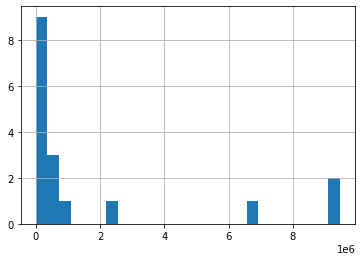

In [16]:
flags.hist(bins = 26)